In [96]:
from typing import List, Dict
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

#from pipeline_attend_and_excite import AttendAndExcitePipeline
from pipeline.sd_pipeline_boxdiff import BoxDiffPipeline
from config import RunConfig
# from run import run_on_prompt, get_indices_to_alter
from run_sd_boxdiff import  get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore, register_attention_control
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Model Weights (may take a few minutes)

In [97]:
import os
os.environ["https_proxy"]='http://127.0.0.1:7890'
os.environ["http_proxy"]='http://127.0.0.1:7890'
os.environ["all_proxy"]='socks5://127.0.0.1:7890'
os.environ["no_proxy"] = "localhost,127.0.0.1,::1"

In [98]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
#stable = AttendAndExcitePipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)
#stable = AttendAndExcitePipeline.from_pretrained("E:/hug_models/stable-diffusion-2-1-base").to(device)
stable = BoxDiffPipeline.from_pretrained("/data/Weili/pretrained_models/stable-diffusion-2-1-base").to(device)
tokenizer = stable.tokenizer

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [99]:
from PIL import Image
def run_on_prompt(prompt: List[str],
                  model: BoxDiffPipeline,
                  controller: AttentionStore,
                  token_indices: List[int],
                  seed: torch.Generator,
                  config: RunConfig,
                  bbox) -> Image.Image:
    if controller is not None:
        register_attention_control(model, controller)
    outputs = model(prompt=prompt,
                    attention_store=controller,
                    indices_to_alter=token_indices,
                    attention_res=config.attention_res,
                    guidance_scale=config.guidance_scale,
                    generator=seed,
                    num_inference_steps=config.n_inference_steps,
                    max_iter_to_alter=config.max_iter_to_alter,
                    run_standard_sd=config.run_standard_sd,
                    thresholds=config.thresholds,
                    scale_factor=config.scale_factor,
                    scale_range=config.scale_range,
                    smooth_attentions=config.smooth_attentions,
                    sigma=config.sigma,
                    kernel_size=config.kernel_size,
                    sd_2_1=config.sd_2_1,
                    bbox=bbox,
                    config=config)
    image = outputs.images[0]
    return image

# Pipeline Wrapper

In [100]:
# configurable parameters (see RunConfig for all parameters)
# scale factor- intensity of shift by gradient
# thresholds- a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    bbox: List[list],
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0: 0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter,
                       save_cross_attention_maps=True)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config,
                          bbox=bbox)
    if display_output:
        display(image)
    return image

# Show Cross-Attention Per Strengthened Token

## Define your seeds, prompt and the indices to strengthen

In [101]:
prompt = "A rabbit wearing sunglasses looks very proud"
seeds = [21]
bbox = [[67,87,366,512],[66,130,364,262]]

In [102]:
token_indices = get_indices_to_alter(stable, prompt)

{1: 'a',
 2: 'rabbit',
 3: 'wearing',
 4: 'sunglasses',
 5: 'looks',
 6: 'very',
 7: 'proud'}
Altering tokens: ['rabbit', 'sunglasses']


## Stable Diffusion

  0%|          | 0/50 [00:00<?, ?it/s]

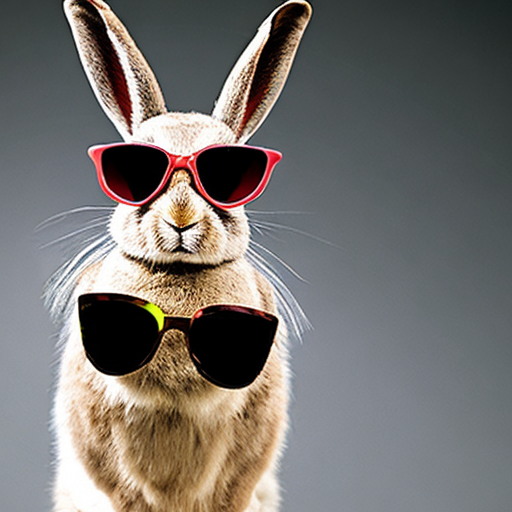

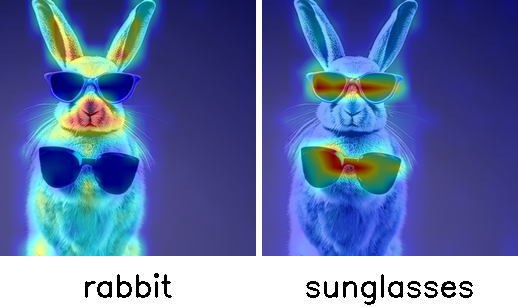

In [103]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            bbox=bbox,
                            run_standard_sd=True,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

## Box-constraint

  0%|          | 0/50 [00:00<?, ?it/s]

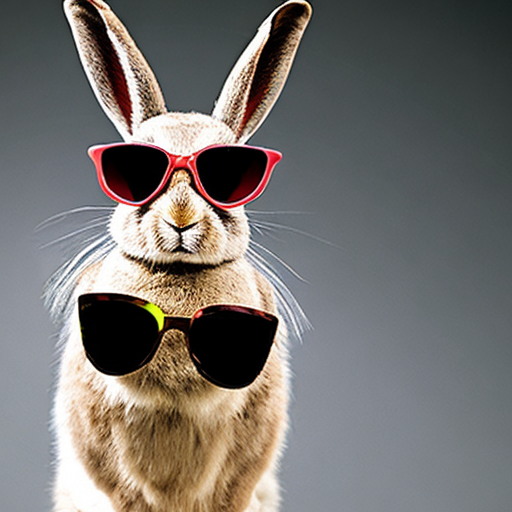

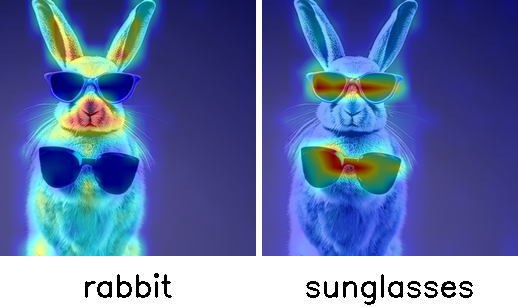

In [104]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            bbox=bbox,
                            run_standard_sd=False,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)